In [1]:
import xarray as xr
import numpy as np
import sys; sys.path.append('../src/training-on-CM2.6')
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
import cmocean
import xgcm
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
R4_FGR3 = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/merged_dataset.nc', decode_times=False)

In [8]:
static = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/static.nc', decode_times=False).squeeze().drop_vars('time')
grid = xgcm.Grid(static, coords={
            'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
        },
        boundary={"X": 'periodic', 'Y': 'fill'},
        fill_value = {'Y':0})

In [10]:
def KEz(ds):
    return 0.5 * (ds.h * (grid.interp(ds.u**2, 'X') + grid.interp(ds.v**2, 'Y'))).sum('zl')

In [11]:
from dask.diagnostics import ProgressBar

In [12]:
R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/snapshots*', decode_times=False).sel(time=slice(29200.1,None))
R4_ann = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/May22-Coriolis-upd/snapshots*', decode_times=False).sel(time=slice(29200.1,None))

In [13]:
with ProgressBar():
    R4_KEz = KEz(R4).compute()

[########################################] | 100% Completed | 40.64 s


In [14]:
with ProgressBar():
    R4_ann_KEz = KEz(R4_ann).compute()

[########################################] | 100% Completed | 45.12 s


In [15]:
with ProgressBar():
    R4_FGR3_KEz = KEz(R4_FGR3.rename({'hf':'h','uf':'u','vf':'v'})).compute()

In [16]:
import matplotlib as mpl

default_rcParams({'figure.subplot.wspace': 0.0, 'figure.subplot.hspace': 0.3, 'font.size': 14})

def plot(idx=0, zl=slice(None,None)):
    plt.figure(figsize=(7,6))
    for col, (exp, label) in enumerate(
        zip(
        [R4_KEz, 
         R4_ann_KEz, 
         R4_FGR3_KEz],
        [
         '$1/4^{\circ}$, Control',
         '$1/4^{\circ}$, ANN',
         '$1/32^{\circ}$ filtered \nand coarsegrained']
        )):
        plt.subplot(1,3,col+1)
        KE = exp
        KE = KE.isel(time=idx%len(KE.time))
        im = KE.plot.imshow(
            norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e+3),
            cmap='inferno',
            add_colorbar=False,
            interpolation='none'
        )
        plt.gca().axes.set_aspect('equal')
        plt.xlabel('')
        plt.ylabel('')
        plt.title(label, fontsize=12)
        lons = [10,30,50]
        plt.xticks(lons, [f'${lon}^'+'{\circ}$E' for lon in lons])
        if col==0:
            lats = [-60, -40, -20, 0, 20, 40, 60]
            lat_ticks = [f'${-lat}^'+'{\circ}$S' if lat<0 else f'${lat}^'+'{\circ}$N' for lat in lats]
            plt.yticks(lats, lat_ticks)
        else:
            plt.yticks([])
            
    plt.colorbar(im, pad=0.08, aspect=100, orientation='horizontal', ax=plt.gcf().axes, extend='both').set_label(fontsize=13, label='Depth-integrated KE, $\mathrm{m}^3 \mathrm{s}^{-2}$')

CPU times: user 61.5 ms, sys: 5.85 ms, total: 67.3 ms
Wall time: 205 ms


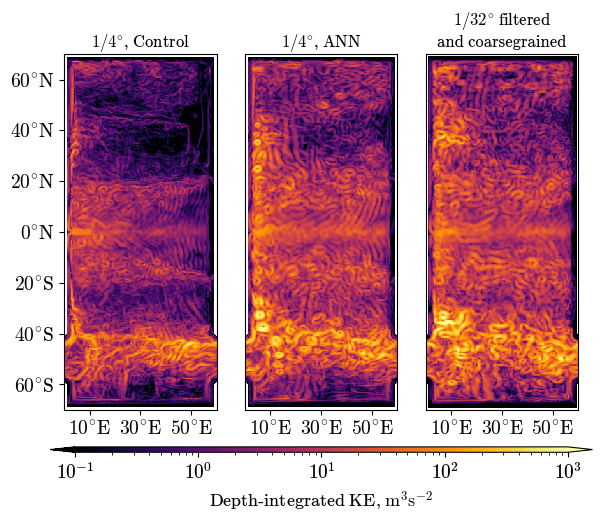

In [17]:
%time plot(0)


KeyboardInterrupt



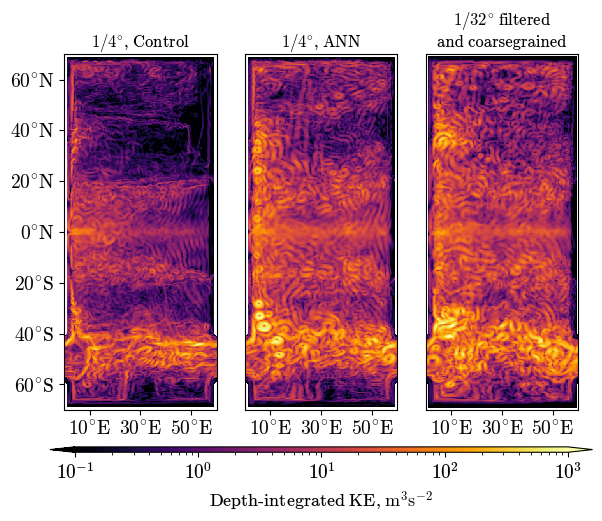

In [18]:
from helpers.plot_helpers import create_animation_ffmpeg
%time create_animation_ffmpeg(plot, range(0,160), FPS=20, filename='Movie.mp4', dpi=150)